In [1]:
import random
from captcha.image import ImageCaptcha
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from claptcha import Claptcha
import tensorflow as tf
%matplotlib inline


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def random_captcha_text():
    number = list(map(lambda x: str(x), list(range(100))))
    operator = ['+', '-']
    e1 = random.choice(number)
    e2 = random.choice(number)
    op = random.choice(operator)
    captcha_text = [e1, ' ', op, ' ', e2, '=', '?']
    return ''.join(captcha_text), (e1, op, e2)

In [97]:
import numpy as np
import tensorflow as tf
import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import os


class CaptchaCracker:
    def __init__(self, model_path='./model_checkpoint'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        self.model_file = model_path + '/captcha_model'
        self.Y_DIM = 202
        self.NUMBER_COUNT = 100
        self.OP_COUNT = 2
        self.IMG_HEIGHT = 20
        self.IMG_WIDTH = 90
        self.learning_rate = 0.001
        self.target_acc = 0.95
    
    def build(self, w_alpha=0.01, b_alpha=0.1):
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, [None, self.IMG_HEIGHT * self.IMG_WIDTH])
        self.Y = tf.placeholder(tf.float32, [None, self.Y_DIM])
        self.keep_prob = tf.placeholder(tf.float32)
        self.x_input = tf.reshape(self.X, shape=[-1, self.IMG_HEIGHT, self.IMG_WIDTH, 1])
        
        with tf.variable_scope('cnn'):
            self.conv1 = tf.contrib.layers.conv2d(inputs=self.x_input, num_outputs=32, stride=1, kernel_size=3, padding='SAME')
            self.maxp1 = tf.contrib.layers.max_pool2d(inputs=self.conv1, kernel_size=2, stride=1, padding='SAME')
            self.drop1 = tf.contrib.layers.dropout(inputs=self.maxp1, keep_prob=self.keep_prob)
            
            self.conv2 = tf.contrib.layers.conv2d(inputs=self.drop1, num_outputs=64, stride=1, kernel_size=3, padding='SAME')
            self.maxp2 = tf.contrib.layers.max_pool2d(inputs=self.conv2, kernel_size=2, stride=1, padding='SAME')
            self.drop2 = tf.contrib.layers.dropout(inputs=self.maxp2, keep_prob=self.keep_prob)
            
            self.conv3 = tf.contrib.layers.conv2d(inputs=self.drop2, num_outputs=128, stride=1, kernel_size=3, padding='SAME')
            self.maxp3 = tf.contrib.layers.max_pool2d(inputs=self.conv3, kernel_size=2, stride=1, padding='SAME')
            self.drop3 = tf.contrib.layers.dropout(inputs=self.maxp3, keep_prob=self.keep_prob)
        
        with tf.variable_scope('dense'):
            self.flatten = tf.contrib.layers.flatten(inputs=self.drop3)
            self.dense1 = tf.contrib.layers.fully_connected(inputs=self.flatten, activation_fn=tf.nn.relu, num_outputs=1024)
            self.dense_drop1 = tf.contrib.layers.dropout(inputs=self.dense1, keep_prob=self.keep_prob)
            
            self.dense2 = tf.contrib.layers.fully_connected(inputs=self.dense_drop1, activation_fn=tf.nn.relu, num_outputs=512)
            self.dense_drop2 = tf.contrib.layers.dropout(inputs=self.dense2, keep_prob=self.keep_prob)
            
            self.dense3 = tf.contrib.layers.fully_connected(inputs=self.dense_drop2, activation_fn=tf.nn.relu, num_outputs=self.Y_DIM)
            self.output = tf.contrib.layers.dropout(inputs=self.dense3, keep_prob=self.keep_prob)
        
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.output, labels=self.Y))
        
        with tf.variable_scope('train'):
            self.optimize = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        with tf.variable_scope('predict'):
            self.predict_e1 = tf.argmax(self.output[:, :self.NUMBER_COUNT], 1)
            self.predict_e2 = tf.argmax(self.output[:, self.NUMBER_COUNT:self.NUMBER_COUNT * 2], 1)
            self.predict_o = tf.argmax(self.output[:, self.NUMBER_COUNT * 2:], 1)
            self.true_e1 = tf.argmax(self.Y[:, :self.NUMBER_COUNT], 1)
            self.true_e2 = tf.argmax(self.Y[:, self.NUMBER_COUNT:self.NUMBER_COUNT * 2], 1)
            self.true_o = tf.argmax(self.Y[:, self.NUMBER_COUNT * 2:], 1)
            self.correct_e1 = tf.equal(self.predict_e1, self.true_e1)
            self.correct_e2 = tf.equal(self.predict_e2, self.true_e2)
            self.correct_o = tf.equal(self.predict_o, self.true_o)
            self.accuracy_e1 = tf.reduce_mean(tf.cast(self.correct_e1, tf.float32))
            self.accuracy_e2 = tf.reduce_mean(tf.cast(self.correct_e2, tf.float32))
            self.accuracy_o = tf.reduce_mean(tf.cast(self.correct_o, tf.float32))
            self.accuracy = (self.accuracy_e1 + self.accuracy_e2 + self.accuracy_o) / 3
        self.saver = tf.train.Saver()
    
    @staticmethod
    def make_captcha_text(e1, e2, op):
        number = list(map(lambda x: str(x), list(range(100))))
        operator = ['+', '-']
        captcha_text = [number[e1], ' ', operator[op], ' ', number[e2],' ', '=', '?']
        return ''.join(captcha_text), (e1, op, e2)
    
    @staticmethod
    def create_specific_validate_code(string, chars, size=(90, 20), mode="1", font_size=18, font_type="Cambria.ttf", draw_points=True, clear=90):
        width, height = size
        img = Image.new(mode, size)
        draw = ImageDraw.Draw(img)
        
        def create_points():
            chance = min(100, max(0, int(clear)))
            for w in range(width):
                for h in range(height):
                    tmp = random.randint(0, 100)
                    if tmp > 100 - chance:
                        draw.point((w, h), fill=1)
        
        def create_str():
            font = ImageFont.truetype(font_type, font_size)
            font_width, font_height = font.getsize(string)
            draw.text(((width - font_width) / 4, (height - font_height) / 4),
                      string, font=font)
        
        if draw_points:
            create_points()
        create_str()
        return np.array(img.convert('L')), chars
    
    @staticmethod
    def pre_process(image):
        return np.array(image.filter(ImageFilter.SHARPEN).convert('1').filter(ImageFilter.DETAIL).convert('L'))
    
    @staticmethod
    def char2vec(chars, number_count=100, op_count=2):
        vec = np.zeros(number_count * 2 + op_count)
        vec[chars[0]] = 1
        vec[number_count + chars[2]] = 1
        vec[number_count * 2 + chars[1]] = 1
        return vec
    
    @staticmethod
    def vec2char(vec, number_count=100):
        number = list(range(number_count)) + list(range(number_count))
        op = ['+', '-']
        i1, i2, io = tuple(np.where(vec == 1)[0])
        return number[i1], number[i2 - number_count], op[io - number_count * 2]
    
    def get_big_batch(self, i):
        batch_x = np.zeros([self.NUMBER_COUNT * self.OP_COUNT, self.IMG_HEIGHT * self.IMG_WIDTH])
        batch_y = np.zeros([self.NUMBER_COUNT * self.OP_COUNT, self.Y_DIM])
        count = 0
        for j in range(self.NUMBER_COUNT):
            for k in range(self.OP_COUNT):
                strs, chars = self.make_captcha_text(i, j, k)
                image, text = self.create_specific_validate_code(string=strs, chars=chars)
                batch_x[count, :] = image.flatten() / 255
                batch_y[count, :] = self.char2vec(text)
                count += 1
        return batch_x, batch_y
    
    def train(self):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            step = 0
            while True:
                digit_accs = []
                for i in range(self.NUMBER_COUNT):
                    batch_x, batch_y = self.get_big_batch(i)
                    _, acc, acc_e1, acc_e2, acc_o, loss_ = sess.run([self.optimize, self.accuracy, self.accuracy_e1, self.accuracy_e2, self.accuracy_o, self.loss], feed_dict={self.X: batch_x, self.Y: batch_y, self.keep_prob: 0.75})
                    print('step: ', step, 'acc: ', acc, 'loss: ', loss_, 'acc_e1: ', acc_e1, 'acc_e2: ', acc_e2, 'acc_o: ', acc_o)
                    digit_accs.append(acc)
                    step += 1
                if np.mean(digit_accs) > self.target_acc:
                    self.saver.save(sess, self.model_file)
                    break
    
    def predict(self, x):
        with tf.Session() as sess:
            self.saver.restore(sess, self.model_file)
            pe1, pe2, po = sess.run([self.predict_e1, self.predict_e2, self.predict_o], feed_dict={self.X: x, self.keep_prob: 1.})
            return pe1, pe2, po

# if __name__ == '__main__':
#     model=CaptchaCracker('./model_cpt')
#     model.build()
#     model.train()

In [98]:
model=CaptchaCracker()
model.build()
# model.train()

In [99]:
X,Y=model.get_big_batch(0)

In [100]:
strs,chars=model.make_captcha_text(0,25,0)

In [101]:
X_0=model.create_specific_validate_code(string=strs,chars=chars)[0]

In [102]:
X_0

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [103]:
Image.fromarray(np.array((X_0.flatten()/255.0).reshape((20,90))*255,dtype=np.uint8),mode='L')

In [105]:
X_0/255

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [106]:
Image.open('../patentCrawler/captcha.jpg')

In [107]:
Image.fromarray(model.pre_process(Image.open('../patentCrawler/captcha.jpg')))

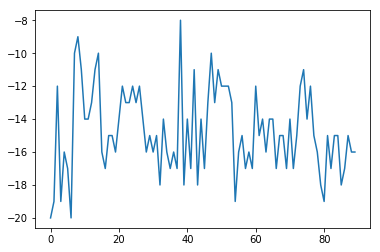

In [108]:
plt.plot(-np.sum(model.pre_process(Image.open('../patentCrawler/captcha.jpg'))/255,axis=0))

In [109]:
sample=model.pre_process(Image.open('../patentCrawler/captcha.jpg'))

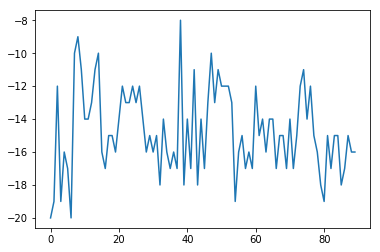

In [110]:
plt.plot(-np.sum(sample/255,axis=0))

In [111]:
Image.fromarray(sample[:,5:30])

In [112]:
Image.fromarray(X_0[:,5:30])

In [13]:
Image.fromarray((X_0.flatten()/255.0).reshape((20,90))*255,mode='L')

In [14]:
Image.fromarray(np.array(X[199]*255,dtype=np.uint8).reshape((20,90)),mode='L')

In [ ]:
model.create_validate_code(chars=)

In [65]:
import numpy as np
import tensorflow as tf
import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import os


class CaptchaCracker:
    def __init__(self, model_path='./model_checkpoint'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        self.model_file = model_path + '/captcha_model'
        self.Y_DIM = 202
        self.NUMBER_COUNT = 100
        self.OP_COUNT = 2
        self.IMG_HEIGHT = 20
        self.IMG_WIDTH = 90
        self.learning_rate= 0.001
        self.target_acc=0.8
     
    
    def build(self, w_alpha=0.01, b_alpha=0.1):
        self.X = tf.placeholder(tf.float32, [None, self.IMG_HEIGHT * self.IMG_WIDTH])
        self.Y = tf.placeholder(tf.float32, [None, self.Y_DIM])
        self.keep_prob = tf.placeholder(tf.float32)
        self.x_input = tf.reshape(self.X, shape=[-1, self.IMG_HEIGHT, self.IMG_WIDTH, 1])
        # 3 conv layer
        self.w_c1 = tf.Variable(w_alpha * tf.random_normal([5, 5, 1, 32]))
        self.b_c1 = tf.Variable(b_alpha * tf.random_normal([32]))
        self.conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.x_input, self.w_c1, strides=[1, 1, 1, 1], padding='SAME'), self.b_c1))
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
        self.conv1 = tf.nn.dropout(self.conv1, self.keep_prob)
        
        self.w_c2 = tf.Variable(w_alpha * tf.random_normal([5, 5, 32, 64]))
        self.b_c2 = tf.Variable(b_alpha * tf.random_normal([64]))
        self.conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.conv1, self.w_c2, strides=[1, 1, 1, 1], padding='SAME'), self.b_c2))
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
        self.conv2 = tf.nn.dropout(self.conv2, self.keep_prob)
        
        self.w_c3 = tf.Variable(w_alpha * tf.random_normal([5, 5, 64, 64]))
        self.b_c3 = tf.Variable(b_alpha * tf.random_normal([64]))
        self.conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(self.conv2, self.w_c3, strides=[1, 1, 1, 1], padding='SAME'), self.b_c3))
        self.conv3 = tf.nn.max_pool(self.conv3, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
        self.conv3 = tf.nn.dropout(self.conv3, self.keep_prob)
        print(self.conv3.shape)
        # Fully connected layer
        self.w_d = tf.Variable(w_alpha * tf.random_normal([3 * 12 * 64, 1024]))
        self.b_d = tf.Variable(b_alpha * tf.random_normal([1024]))
        self.dense = tf.reshape(self.conv3, [-1, self.w_d.get_shape().as_list()[0]])
        self.dense = tf.nn.relu(tf.add(tf.matmul(self.dense, self.w_d), self.b_d))
        self.dense = tf.nn.dropout(self.dense, self.keep_prob)
        
        self.w_out = tf.Variable(w_alpha * tf.random_normal([1024, self.Y_DIM]))
        self.b_out = tf.Variable(b_alpha * tf.random_normal([self.Y_DIM]))
        self.output = tf.add(tf.matmul(self.dense, self.w_out), self.b_out)
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.output, labels=self.Y))
        self.optimize = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        self.predict_e1 = tf.argmax(self.output[:, :self.NUMBER_COUNT], 1)
        self.predict_e2 = tf.argmax(self.output[:, self.NUMBER_COUNT:self.NUMBER_COUNT * 2], 1)
        self.predict_o = tf.argmax(self.output[:, self.NUMBER_COUNT * 2:], 1)
        self.true_e1 = tf.argmax(self.Y[:, :self.NUMBER_COUNT], 1)
        self.true_e2 = tf.argmax(self.Y[:, self.NUMBER_COUNT:self.NUMBER_COUNT * 2], 1)
        self.true_o = tf.argmax(self.Y[:, self.NUMBER_COUNT * 2:], 1)
        self.correct_e1 = tf.equal(self.predict_e1, self.true_e1)
        self.correct_e2 = tf.equal(self.predict_e2, self.true_e2)
        self.correct_o = tf.equal(self.predict_o, self.true_o)
        self.accuracy_e1 = tf.reduce_mean(tf.cast(self.correct_e1, tf.float32))
        self.accuracy_e2 = tf.reduce_mean(tf.cast(self.correct_e2, tf.float32))
        self.accuracy_o = tf.reduce_mean(tf.cast(self.correct_o, tf.float32))
        self.accuracy = (self.accuracy_e1 + self.accuracy_e2 + self.accuracy_o) / 3
        self.saver = tf.train.Saver()
    

    def make_captcha_text(self, e1, e2, op):
        number = list(map(lambda x: str(x), list(range(100))))
        operator = ['+', '-']
        captcha_text = [number[e1], ' ', operator[op], ' ', number[e2], '=', '?']
        return ''.join(captcha_text), (e1, op, e2)

    def create_specific_validate_code(self, strs, chars, size=(90, 20), mode="1", font_size=18, font_type="arial.ttf", draw_points=True, clear=80):
        width, height = size
        img = Image.new(mode, size)
        draw = ImageDraw.Draw(img)
        def create_points():
            chance = min(100, max(0, int(clear)))
            for w in range(width):
                for h in range(height):
                    tmp = random.randint(0, 100)
                    if tmp > 100 - chance:
                        draw.point((w, h), fill=1)
    
        def create_strs():
            font = ImageFont.truetype(font_type, font_size)
            font_width, font_height = font.getsize(strs)
            draw.text(((width - font_width) / 4, (height - font_height) / 4),
                      strs, font=font)
    
        if draw_points:
            create_points()
        create_strs()
        return np.array(img.convert('L')), chars
    
    
    def pre_process(self, image):
        return np.array(image.filter(ImageFilter.SHARPEN).convert('1').filter(ImageFilter.DETAIL).convert('L'))

    def char2vec(self, chars, number_count=100, op_count=2):
        vec = np.zeros(number_count * 2 + op_count)
        vec[chars[0]] = 1
        vec[number_count + chars[2]] = 1
        vec[number_count * 2 + chars[1]] = 1
        return vec
    
    def vec2char(self, vec,number_count=100, op_count=2):
        number=list(range(number_count))+list(range(number_count))
        op=['+','-']
        i1, i2, io = tuple(np.where(vec == 1)[0])
        return (number[i1], number[i2 - number_count], op[io - number_count * 2])
    

    def get_big_batch(self, i):
        batch_x = np.zeros([self.NUMBER_COUNT * self.OP_COUNT, self.IMG_HEIGHT * self.IMG_WIDTH])
        batch_y = np.zeros([self.NUMBER_COUNT * self.OP_COUNT, self.Y_DIM])
        count = 0
        for j in range(self.NUMBER_COUNT):
            for k in range(self.OP_COUNT):
                strs, chars = self.make_captcha_text(i, j, k)
                image, text = self.create_specific_validate_code(strs=strs, chars=chars)
                batch_x[count, :] = image.flatten() / 255
                batch_y[count, :] = self.char2vec(text)
                count += 1
        return batch_x, batch_y
    
    
    def train(self):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            step = 0
            while True:
                digit_accs = []
                for i in range(self.NUMBER_COUNT):
                    batch_x, batch_y = self.get_big_batch(i)
                    _, acc, acc_e1, acc_e2, acc_o, loss_ = sess.run([self.optimize, self.accuracy, self.accuracy_e1, self.accuracy_e2, self.accuracy_o, self.loss], feed_dict={self.X: batch_x, self.Y: batch_y, self.keep_prob: 0.75})
                    print('step: ', step, 'acc: ', acc, 'loss: ', loss_, 'acc_e1: ', acc_e1, 'acc_e2: ', acc_e2, 'acc_o: ', acc_o)
                    digit_accs.append(acc)
                    step += 1
                if np.mean(digit_accs) > self.target_acc:
                    self.saver.save(sess, self.model_file)
                    break
            step += 1
    def predict(self,image):
        with tf.Session() as sess:
            self.saver.restore(sess,self.model_file)
            x = np.expand_dims(image.flatten(), axis=0)
            pe1, pe2, po = sess.run([self.predict_e1, self.predict_e2, self.predict_o], feed_dict={self.X: x, self.keep_prob: 1.})
            return pe1,pe2,po

# if __name__ == '__main__':
#     model=CaptchaCracker(model_path='./model_checkpoint1')
#     model.build()
#     model.train()
    # print(model.predict(model.pre_process(Image.open('captcha.jpg'))))
    
    


In [66]:
model=CaptchaCracker()

In [67]:
model.build()

(?, 20, 90, 64)


In [38]:
Image.fromarray(model.create_specific_validate_code(model.make_captcha_text(12,24,0)[0],model.make_captcha_text(12,24,0)[1])[0])

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPool2D,Dropout

In [ ]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding='same', input_shape=input_shape)) 
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='valid')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='valid')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
#sgd = SGD(l2=0.0, lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])